Replacing `https://github.com` by `https://colab.research.google.com/github` as mentioned in [stackoverflow](https://stackoverflow.com/questions/62596466/how-can-i-run-notebooks-of-a-github-project-in-google-colab)

### Download data

In [1]:
# if run in Google colab
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/coco2017labels-segments.zip -P data
!pwd
!cd data && unzip coco2017labels-segments.zip > load_data.log

--2025-09-21 06:51:28--  https://github.com/WongKinYiu/yolov7/releases/download/v0.1/coco2017labels-segments.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/511187726/357220aa-7581-46ee-b083-15df658c80fc?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-09-21T07%3A47%3A12Z&rscd=attachment%3B+filename%3Dcoco2017labels-segments.zip&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-09-21T06%3A46%3A58Z&ske=2025-09-21T07%3A47%3A12Z&sks=b&skv=2018-11-09&sig=k%2Bhcqk8P7WNsDcF2mhWrVG78Lb9iKy39FYWR9%2BE%2B7b0%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1ODQzNzc4OCwibmJmIjoxNzU4NDM3NDg4LCJwYXRoIjoicmVsZWFz

In [2]:
!pwd
# !wget http://images.cocodataset.org/zips/train2017.zip -P data/coco/images
# !cd data/coco/images && unzip train2017.zip > load_data.log
!wget http://images.cocodataset.org/zips/val2017.zip -P data/coco/images
!cd data/coco/images && unzip val2017.zip > load_data.log

/content
--2025-09-21 06:52:24--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.25.169, 54.231.234.145, 52.217.125.137, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.25.169|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘data/coco/images/val2017.zip’

val2017.zip         100%[===================>] 777.80M   106MB/s    in 9.7s    

2025-09-21 06:52:34 (79.9 MB/s) - ‘data/coco/images/val2017.zip’ saved [815585330/815585330]



Check image and label files

In [1]:
import os
import numpy as np

for dirname in ['train2017', 'val2017']:
    txt=''
    for subdir in ['images', 'labels']:
        dirpath=f'data/coco/{subdir}/{dirname}'
        if not os.path.isdir(dirpath): continue
        txt+='{} {} of {}, '.format(len(os.listdir(dirpath)),subdir,
                      np.unique([os.path.splitext(file)[-1] for file in os.listdir(dirpath)]) )
    print(f'{dirname}: {txt}')

train2017: 0 images of [], 117266 labels of ['.txt'], 
val2017: 5000 images of ['.jpg'], 4952 labels of ['.txt'], 


### Get python scripts and configuration files

In [4]:
!git clone https://github.com/s-reaungamornrat/video_processing.git

Cloning into 'video_processing'...
remote: Enumerating objects: 293, done.
remote: Counting objects: 100% (293/293), done.
remote: Compressing objects: 100% (185/185), done.
remote: Total 293 (delta 123), reused 252 (delta 86), pack-reused 0 (from 0)
Receiving objects: 100% (293/293), 19.08 MiB | 22.80 MiB/s, done.
Resolving deltas: 100% (123/123), done.


In [14]:
# !wget https://github.com/WongKinYiu/yolov7/blob/main/cfg/training/yolov7-w6.yaml
# !wget https://github.com/WongKinYiu/yolov7/blob/main/data/hyp.scratch.p6.yaml
# !wget https://github.com/WongKinYiu/yolov7/blob/main/data/coco.yaml

### Model training code

In [2]:
%matplotlib inline

import re
import sys
import yaml
import random

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

seed=0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed);

In [3]:
# %load_ext autoreload
# %autoreload 2

from video_processing.yolov7.parameter_parser import parser
from video_processing.yolov7.models.model import Model
from video_processing.yolov7.models.ema import ModelEMA
from video_processing.yolov7.loss.module import ComputeLoss
from video_processing.yolov7.train.utils import setup_optimizer, labels_to_class_weights, train_an_epoch
from video_processing.yolov7.dataset.coco_dataset import LoadImagesAndLabels
from video_processing.yolov7.utils.general import one_cycle, check_image_size
from video_processing.yolov7.dataset.anchors import check_anchor_matching
from video_processing.yolov7.test.utils import validation

In [4]:
data_dirpath='data/coco'
result_dirpath='results'

argument=f"""
--data-dirpath {data_dirpath} --output-dirpath {result_dirpath}
--worker 1 --device cuda --batch-size 2 --data coco.yaml --img 1280 1280 --cfg yolov7-w6.yaml
--weights ''  --name yolov7-w6 --hyp hyp.scratch.p6.yaml --correct-exif
--print-freq 1000
"""
# --n-training-data 100 --n-val-data 20 --dev-mode
args=parser.parse_args(argument.split())

device=torch.device('cpu' if not torch.cuda.is_available() or args.device=='cpu' else 'cuda')
if device==torch.device('cuda'):
    print('Delete cache memory')
    torch.cuda.empty_cache()
print('device ', device, ' batch size ', args.batch_size)

if not os.path.isdir(args.output_dirpath):os.makedirs(args.output_dirpath)
args.checkpoint_dirpath=os.path.join(args.output_dirpath, args.checkpoint_dirname)
if not os.path.isdir(args.checkpoint_dirpath): os.makedirs(args.checkpoint_dirpath)

device  cpu  batch size  2


In [8]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [5]:
# hyperparameters
with open(args.hyp) as f: hyp=yaml.load(f, Loader=yaml.SafeLoader)
# data
with open(args.data) as f: data_dict=yaml.load(f, Loader=yaml.SafeLoader)
# number of classes
nc=1 if args.single_cls else int(data_dict['nc'])
names=['item'] if args.single_cls and len(data_dict['names'])!=1 else data_dict['names'] # class names
assert len(names)==nc, f'There are {len(names)} class names but {nc} classes'

In [6]:
# define model and optimizers
model=Model(args.cfg, ch=3, nc=nc, anchors=hyp.get('anchors')).to(device)  # it is safer to move model to device first and then create optimizer
optimizer=setup_optimizer(model, learning_rate=hyp['lr0'], momentum=hyp['momentum'], weight_decay=hyp['weight_decay'])
scheduler=torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=one_cycle(1., hyp['lrf'], args.epochs))
model_ema=ModelEMA(model)
start_epoch, best_fitness=1, -np.inf
if args.resume is not None and os.path.isfile(os.path.join(args.checkpoint_dirpath, args.resume)):
    resume_fpath=os.path.join(args.checkpoint_dirpath, args.resume)
    if os.path.isfile(os.path.join(args.checkpoint_dirpath, args.best_checkpoint_fname)):
        resume_fpath=os.path.join(args.checkpoint_dirpath, args.best_checkpoint_fname)
    checkpoint = torch.load(resume_fpath, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    scheduler.load_state_dict(checkpoint['scheduler'])
    start_epoch = checkpoint['epoch']+1
    best_fitness=checkpoint['best_fitness']
    model_ema.ema.load_state_dict(checkpoint['ema'])
    model_ema.updates=checkpoint['updates']

# check that the image size divisible by stride
max_stride=max(int(model.stride.max()), 32)
assert check_image_size(image_size=args.img_size, stride=max_stride), f'{args.img_size} must be divisible by {max_stride}'

In IAxDetect nl: 4 na: 3
In IAxDetect anchors: torch.Size([4, 3, 2]) 4x3x2
In IAxDetect anchor_grid: torch.Size([4, 1, 3, 1, 1, 2]) 4x1x3x1x1x2


In [8]:
# train/val data loader
train_dataset=LoadImagesAndLabels(data_dirpath=args.data_dirpath, image_paths=data_dict['train'], img_size=args.img_size[0],
                            augment=True, hyp=hyp, n_data=args.n_training_data, correct_exif=args.correct_exif)
val_dataset=LoadImagesAndLabels(data_dirpath=args.data_dirpath, image_paths=data_dict['val'], img_size=args.img_size[0],
                            augment=False, hyp=hyp, n_data=args.n_val_data, correct_exif=args.correct_exif)

train_loader=torch.utils.data.DataLoader(dataset=train_dataset, batch_size=args.batch_size, num_workers=1, pin_memory=True,
                                        collate_fn=LoadImagesAndLabels.collate_fn)
val_loader=torch.utils.data.DataLoader(dataset=val_dataset, batch_size=args.batch_size, num_workers=1, pin_memory=True,
                                        collate_fn=LoadImagesAndLabels.collate_fn)

check_anchor_matching(dataset=train_dataset, model=model, thr=4., imgsz=args.img_size[0])

Streaming output truncated to the last 5000 lines.
3 data/coco/images/val2017/000000463618.jpg True
4 data/coco/images/val2017/000000568981.jpg True
5 data/coco/images/val2017/000000092416.jpg True
6 data/coco/images/val2017/000000173830.jpg True
7 data/coco/images/val2017/000000476215.jpg True
8 data/coco/images/val2017/000000479126.jpg True
9 data/coco/images/val2017/000000570664.jpg True
10 data/coco/images/val2017/000000304396.jpg True
11 data/coco/images/val2017/000000231339.jpg True
12 data/coco/images/val2017/000000153510.jpg True
13 data/coco/images/val2017/000000011051.jpg True
14 data/coco/images/val2017/000000237984.jpg True
15 data/coco/images/val2017/000000124798.jpg True
16 data/coco/images/val2017/000000441491.jpg True
17 data/coco/images/val2017/000000361268.jpg True
18 data/coco/images/val2017/000000272566.jpg True
19 data/coco/images/val2017/000000160864.jpg True
20 data/coco/images/val2017/000000078959.jpg True
21 data/coco/images/val2017/000000047571.jpg True
22 dat

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


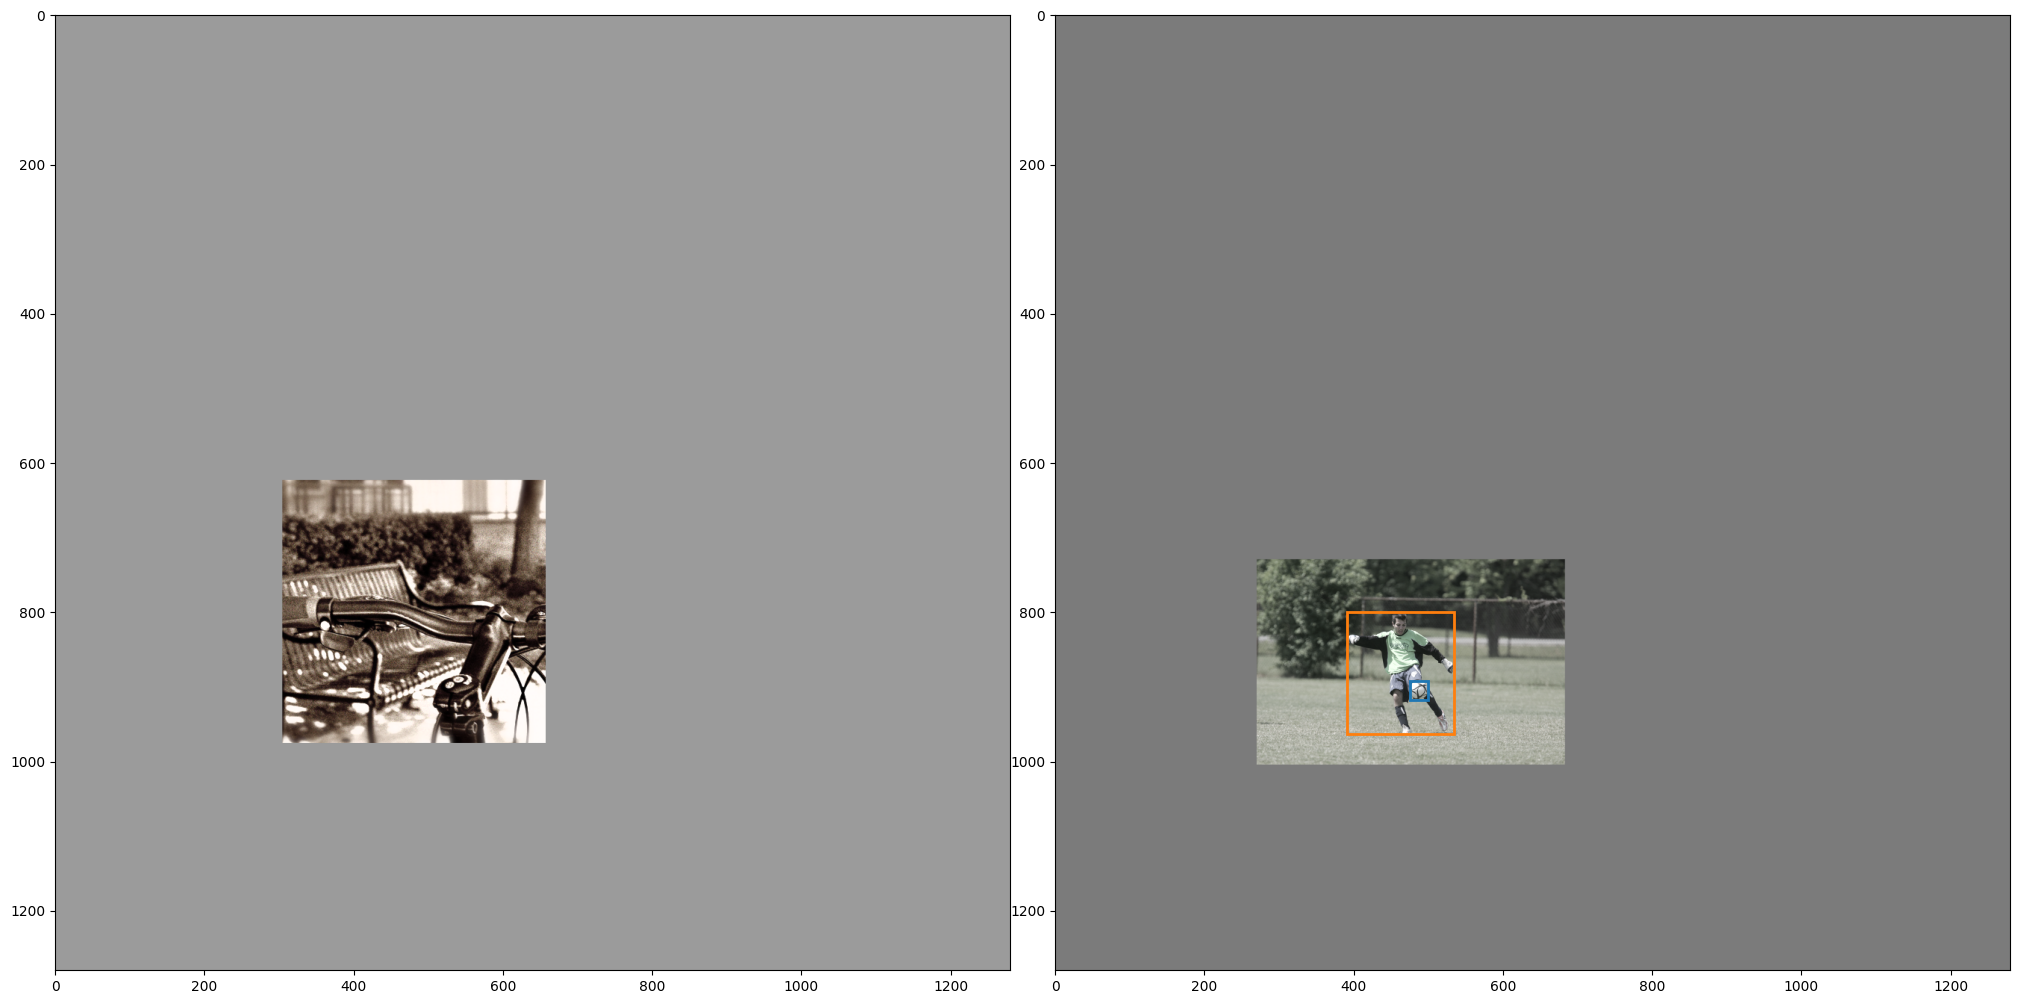

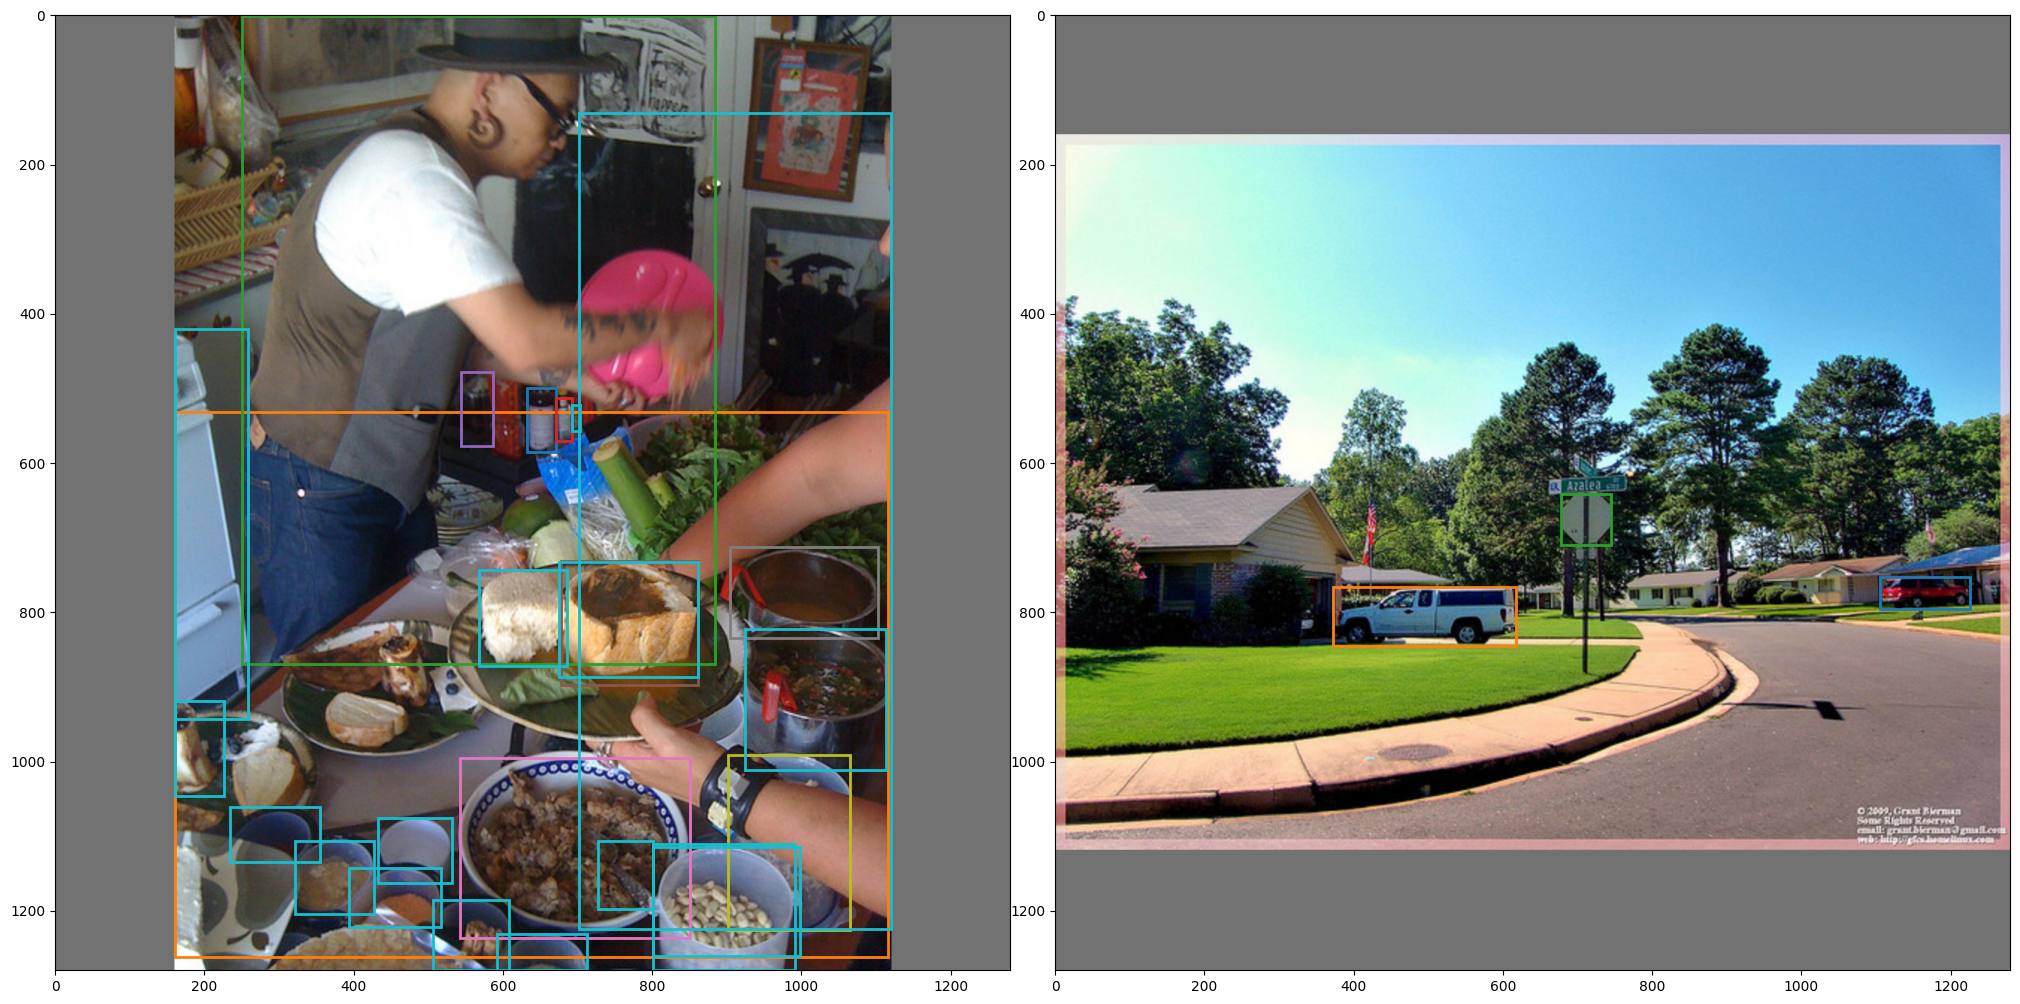

In [12]:
from matplotlib import patches
from video_processing.yolov7.dataset.coords import normalized_xywh2xyxy

n_cols=2
cmap = plt.get_cmap('tab10', 10)
imgs, labels, fpath,_=next(iter(train_loader))
n_rows=int(np.ceil(imgs.shape[0]/n_cols))
_, axes=plt.subplots(n_rows,n_cols,figsize=(20,10))

for r in range(n_rows):
    for c in range(n_cols):
        i=r*n_cols+c
        if i>imgs.shape[0]-1: break
        img=imgs[i]
        is_box=labels[:,0]==i # box of this image
        boxes=labels[:,2:][is_box]
        boxes=normalized_xywh2xyxy(boxes,w=img.shape[-1], h=img.shape[1])
        try: axes[r,c].imshow(img.permute(1,2,0)) # CxHxW to HxWxC
        except: axes[i].imshow(img.permute(1,2,0)) # CxHxW to HxWxC
        for j, box in enumerate(boxes):
            # Create a Rectangle patch
            rect = patches.Rectangle(box[:2], box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor=cmap(j), facecolor='none')
            # Add the patch to the Axes
            try: axes[r,c].add_patch(rect)
            except: axes[i].add_patch(rect)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)

imgs, labels, fpath,_=next(iter(val_loader))
n_rows=int(np.ceil(imgs.shape[0]/n_cols))
_, axes=plt.subplots(n_rows,n_cols,figsize=(20,10))
for r in range(n_rows):
    for c in range(n_cols):
        i=r*n_cols+c
        if i>imgs.shape[0]-1: break
        img=imgs[i]
        is_box=labels[:,0]==i # box of this image
        boxes=labels[:,2:][is_box]
        boxes=normalized_xywh2xyxy(boxes,w=img.shape[-1], h=img.shape[1])
        try: axes[r,c].imshow(img.permute(1,2,0)) # CxHxW to HxWxC
        except: axes[i].imshow(img.permute(1,2,0)) # CxHxW to HxWxC
        for j, box in enumerate(boxes):
            # Create a Rectangle patch
            rect = patches.Rectangle(box[:2], box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor=cmap(j), facecolor='none')
            # Add the patch to the Axes
            try: axes[r,c].add_patch(rect)
            except: axes[i].add_patch(rect)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)

###### Model parameters

In [13]:
# model parameters
nl=model.model[-1].nl
print("hyp['box'] ", hyp['box'],  " hyp['cls'] ", hyp['cls'], " hyp['obj] ", hyp['obj'] )
hyp['box']*=3./nl # box-regression loss weight scaled to layer
hyp['cls']*= nc/80. * 3./nl # classification loss weight scaled to classes and layers
hyp['obj']*=(args.img_size[0]/640)**2 *3./nl # objectness loss weight scaled to image size and layers
hyp['label_smoothing']=args.label_smoothing
model.nc=nc # attach number of classes to model
model.hyp=hyp
# blending factor between fixed objectness of 1 and IoU between prediction and ground truth
# used to set target objectness, i.e., target_objectness = (1-gr)+gr*iou
model.gr=1.
print("hyp['box'] ", hyp['box'],  " hyp['cls'] ", hyp['cls'], " hyp['obj] ", hyp['obj'],
      ' args.label_smoothing ', args.label_smoothing )

scheduler.last_epoch=start_epoch-1 # do not move?
train_loss_module=ComputeLoss(model, cls_pw=hyp['cls_pw'], obj_pw=hyp['obj_pw'], label_smoothing=args.label_smoothing, use_aux=True)
val_loss_module=ComputeLoss(model, cls_pw=hyp['cls_pw'], obj_pw=hyp['obj_pw'], label_smoothing=args.label_smoothing, use_aux=False)

hyp['box']  0.05  hyp['cls']  0.3  hyp['obj]  0.7
hyp['box']  0.037500000000000006  hyp['cls']  0.22499999999999998  hyp['obj]  2.0999999999999996  args.label_smoothing  0.0


In [14]:
for epoch in range(start_epoch, args.epochs):

    # train a model
    model.train()
    mean_weighted_loss, mean_unweigthed_loss=train_an_epoch(args, model, model_ema, optimizer, train_loss_module, train_loader, epoch=epoch)

    # scheduler
    scheduler.step()

    # mAP validation model
    model_ema.update_attr(model, include=['yaml', 'nc', 'hyp', 'gr', 'names', 'stride']) #, 'class_weights'])

    # validation
    results, maps, txt=validation(model=model_ema.ema, dataloader=val_loader, val_loss_module=val_loss_module, hyp=hyp,
                             n_classes=1 if args.single_cls else int(data_dict['nc']), conf_thres=0.001, iou_thres=0.6, verbose=False,
                             n_its=1 if args.dev_mode else None)

    # compute model fitness as a weighted combination of [P, R, mAP@.5, mAP@.5-.95]
    w = [0.0, 0.0, 0.1, 0.9]  # weights for [P, R, mAP@0.5, mAP@0.5:0.95]
    fitness=(np.array(results[:4]) * w).sum()

    lr_txt=', '.join([f"{params['lr']:.3f}"  for params in optimizer.param_groups])
    print(f'Epoch {epoch}: fitness {fitness:.3f}, train-loss={mean_weighted_loss[0].item():.3f}, {txt}, lr=({lr_txt})', flush=True)

    # save parameters
    training_state_dict={'epoch': epoch, 'model': model.state_dict(), 'ema':model_ema.ema.state_dict(),  'optimizer': optimizer.state_dict(),
                         'scheduler': scheduler.state_dict(), 'updates':model_ema.updates, 'best_fitness': best_fitness}
    torch.save(training_state_dict, os.path.join(args.checkpoint_dirpath, args.resume))
    if fitness > best_fitness:
        best_fitness=fitness
        training_state_dict['best_fitness']=best_fitness
        torch.save(training_state_dict, os.path.join(args.checkpoint_dirpath, args.best_checkpoint_fname))

    break

1: loss:1.531,  w-bb:0.060, w-obj:1.429, w-cls:0.043 | bb:1.597, obj:0.680, cls:0.190
Epoch 1: fitness 0.000, train-loss=1.531, val-loss=1.421, targets=0, mp=0.000, mr=0.000, map50=0.000, map=0.000, lr=(0.001, 0.001, 0.001)
